In this notebook we are trying to compare the incoming alerting system coming directly from the camera using the script [Reolink/motion_alert.py](Reolink/motion_alert.py) and the output log [Reolink/log/Reolink_motion_alerts_Eingang.log](Reolink/log/Reolink_motion_alerts_Eingang.log) file with the events coming from our YOLO/DeepSORT implementation (module b) stored in [smart_surveillance/log/YOLO4_DeepSORT_Eingang_overview.log]  
*NOTE: as you will see in the appropiate directories there are more than just one log file of the same type - seperated with extensions like _part?.log. This is because we have stopped and reinitiated the scripts during the 2 weeks of monitoring*

first let us write a function that is helping us to digest the log files coming from the camera. As you will find out the structure of this log file is the following:

In [20]:
# show a part of the log file to illustrate the structure of the file
!sed -n 24,50p Reolink/log/Reolink_motion_alerts_Eingang.log

2022-03-28 11:12:21 [    INFO] ====================================================================================
2022-03-28 11:14:28 [    INFO] ===================== Start Monitoring Motion of Reolink Camera ====================
2022-03-28 11:14:28 [    INFO] camera source:           Eingang, frameRate:               20
2022-03-28 11:14:28 [    INFO] resolution:              2560*1920, bitRate:                 8192
2022-03-28 11:14:28 [    INFO] ------------------------------------------------------------------------------------
2022-03-28 11:14:28 [    INFO] start time:              2022-03-28 11:14:29
2022-03-28 11:14:28 [    INFO] ====================================================================================
2022-03-28 11:14:28 [    INFO] alarm area (80, 60):000000000000000000000000000001111111111111111110000000000000000000000000000001110000000000000000000000000000011111111111111111100000000000000000000000000000011100000000000000000000000000000011111111111111111000000000000

as you can see when ever the script was reinitiated it will log the main settings of the camera such as:
+ camera source, 
+ frameRate
+ resolution 
+ bitRate 
+ start time
+ alarm area in a shriked format (rows, columns & mask matrix) 
all of these information are relevant to adjust our cusomized YOLO/DeepSORT module.

After this setting section (HEADER) we will log only when there is an incoming alert coming from the camera denotated by the last column. We did not log when the camera is not triggering an alert because the file would have been exploded otherwise. In addition we can easaly infer when the camera did not show an alarm by just exploding missing values.

Saying this you will also see that we can have multiple intiatins in the same log file indicated by multtiple headings - that is because we changed either something on the settings such that it is resending these adjusted camera settings to adjust for YOLO/DeepSORT or we reinitiated the script

In [22]:
!head -24 Reolink/log/Reolink_motion_alerts_Eingang.log

2022-03-28 11:05:49 [    INFO] ===================== Start Monitoring Motion of Reolink Camera ====================
2022-03-28 11:05:49 [    INFO] camera source:           Eingang, frameRate:               20
2022-03-28 11:05:49 [    INFO] resolution:              2560*1920, bitRate:                 8192
2022-03-28 11:05:49 [    INFO] ------------------------------------------------------------------------------------
2022-03-28 11:05:49 [    INFO] start time:              2022-03-28 11:05:49
2022-03-28 11:05:49 [    INFO] ====================================================================================
2022-03-28 11:05:49 [    INFO] alarm area (80, 60):00000000000000000000000000000111111111111111111000000000000000000000000000000111000000000000000000000000000001111111111111111110000000000000000000000000000001110000000000000000000000000000001111111111111111100000000000000000000000000000011100000000000000000000000000000011111111111111111000000000000000000000000000000111000000000000000

for example we can see this behaviour in the first part of the section. this script was reinitiated at the beginning 3 times until we started to see the first incoming alerts. Between each initiation there was not alert - so no motion detected by the camera.

Now lets write a helper function to digest this log file

In [33]:
import pandas as pd
from datetime import datetime

def clean_reolink_log(path, skip=8):
    # rad in log file and convert it to pandas dataframe for convinience
    reo1 = pd.read_csv(path, skiprows=skip, header=None).rename(columns={1: "source", 2: "API_request",
                                                                     3: "API_code", 4: "Alarm"})
    # the time logging will be thrown in one column we need to separate it - the left site is the camera time 
    # the right part is the logging time
    reo1["Time"] = reo1.loc[:,0].str.split(" \[    INFO] ")
    # pd.to_datetime(reo1.loc[0,0], format='%Y-%m-%d %H:%M:%S')
    # explosion will expand the pandas dataframe
    # we can now extract the camera and log time by just takin every second entry
    ind1 = [True if i % 2 == 0 else False for i in range(len(reo1.Time.explode())) ]
    ind2 = [False if i % 2 == 0 else True for i in range(len(reo1.Time.explode())) ]
    # now we just need to an concatenate it back
    T = pd.concat([reo1.Time.explode().iloc[ind1], reo1.Time.explode().iloc[ind2]], axis=1)
    T.columns = ["camera_time", "log_time"]
    reo1 = pd.concat([T,reo1.loc[:,["source","API_request","API_code","Alarm"]]], axis=1)
    
    # we now convert the time to a datetime and drop all duplicated camera time logs 
    # (the camera fires multiple times per second - for us the granularity of seconds is more than enough)
    # datetime.strptime(reo1.loc[0,"camera_time"], '%Y-%m-%d %M:%S:%f')
    reo1.loc[:,"camera_time"] = pd.to_datetime(reo1.loc[:,"camera_time"], format='%Y-%m-%d %H:%M:%S')
    # we can now just fill the gaps between each notiication with a 0 = no alarm for every second where nothing happens
    reo1 = reo1.drop_duplicates("camera_time").set_index("camera_time").resample('S')#.ffill().fillna(0)
    reo1 = reo1.asfreq(0)
    return reo1



In [41]:
# let take a look at log file part2 which has only one starting intiatin so we don t need to bother about 
# filtering these headers out and split these events - just use skip=8 since we have 8 rows for the camera 
# settings occupied
path = "Reolink/log/Reolink_motion_alerts_Eingang_part2.log"

reo1 = clean_reolink_log(path, skip=8)
print(f"Dimension of the data: {reo1.shape}")
reo1.head()

Dimension of the data: (237918, 5)


,log_time,source,API_request,API_code,Alarm
camera_time,,,,,
2022-03-21 16:25:40,2022-03-21 16:25:39,Eingang,GetMdState,0,1
2022-03-21 16:25:41,2022-03-21 16:25:40,Eingang,GetMdState,0,1
2022-03-21 16:25:42,2022-03-21 16:25:41,Eingang,GetMdState,0,1
2022-03-21 16:25:43,2022-03-21 16:25:42,Eingang,GetMdState,0,1
2022-03-21 16:25:44,2022-03-21 16:25:43,Eingang,GetMdState,0,1


in this form its much easier for us to visualize the data and the incoming alerts. Lets visualize it  

<AxesSubplot:xlabel='camera_time'>

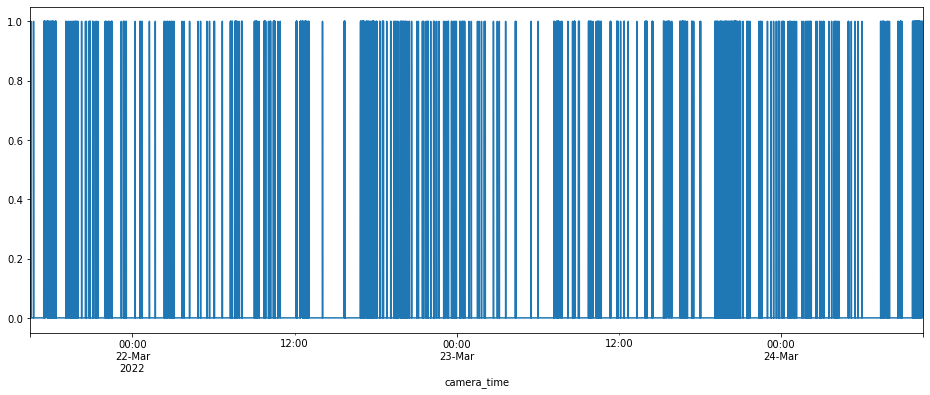

In [42]:
reo1.loc[:,"Alarm"].interpolate(method='linear').plot(figsize = (16,6))

In [58]:
print(f"so as you can see this log file consist of around 3 full days ({str(reo1.index.max()-reo1.index.min())}) without any reintiation.\nNow lets have a look at the other log files")

so as you can see this log file consist of around 3 full days (2 days 18:05:17) without any reintiation.
Now lets have a look at the other log files


as mentioned above there are multiple log files that cover different days - the time between the log files are not captured
Lets concatenate all the log files

In [60]:
import os
import re
# get all Reolink log file paths
path = [l for l in  os.listdir("Reolink/log/") if re.match(".*.log", l)]

# clean the first log file as placeholder from which we will start to concatenate
reo = clean_reolink_log("Reolink/log/" + path[0])
# loop through each log file and take only the last intiation of the log file (was manually checked for each file)
for r,skip in zip(path[1:], [32,48,8,8,8,8,8]):
    print(r)
    reo = reo.append(clean_reolink_log("Reolink/log/" + r, skip))
    
reo.shape

Reolink_motion_alerts_Eingang.log
Reolink_motion_alerts_Eingang_part12.log
Reolink_motion_alerts_Eingang_part4.log
Reolink_motion_alerts_Eingang_part5.log
Reolink_motion_alerts_Eingang_part7.log
Reolink_motion_alerts_Eingang_part1.log
Reolink_motion_alerts_Eingang_part2.log


(1210443, 5)

In [64]:
f"capturing ~2 weeks {str(reo.index.max()-reo.index.min())}"

'capturing ~2 weeks 14 days 04:07:42'

Next lets have a look at the structure of a YOLO/DeepSORT log file we have created


In [65]:
!head smart_surveillance/log/YOLO4_DeepSORT_Eingang_overview.log

2022-03-31 21:22:11 [    INFO] 2560x1920 stream @ 20 FPS
2022-03-31 21:22:11 [    INFO] Loading detector model...
2022-03-31 21:22:18 [    INFO] Loading feature extractor models...
2022-03-31 21:22:18 [    INFO] Starting video capture...
2022-04-01 07:34:48 [    INFO] Found:        person       1 at (2364, 1549)
2022-04-01 07:34:48 [    INFO] Snap:         FaceRecognition/FaceNet_input/Eingang/in_of_interest_area/trackID_1/2022April01_07_34_48_Eingang476191_crop_track_1.png,Eingang,476191,1,2216.000000,1215.000000,286.000000,669.000000
2022-04-01 07:34:49 [    INFO] Snap:         FaceRecognition/FaceNet_input/Eingang/in_of_interest_area/trackID_1/2022April01_07_34_49_Eingang476211_crop_track_1.png,Eingang,476211,1,2077.000000,1211.000000,368.000000,709.000000
2022-04-01 07:34:50 [    INFO] Snap:         FaceRecognition/FaceNet_input/Eingang/in_of_interest_area/trackID_1/2022April01_07_34_50_Eingang476231_crop_track_1.png,Eingang,476231,1,2052.000000,1198.000000,448.000000,718.000000
20

we can see that we also have here a header (4 rows long) where we find:
+ the resolution of the video stream 
+ how fast it is (FPS = frames per second) 
+ when it was started
after that you will see it took around 10h until we have our next event. This is because obviously there was no one in fron t of the camera (at least no human being) over the night.

the structure of the following log file is a starting or ending event for a certain track denotated as 
+ Found: when ever a person was detected and confirmed by the following 5 frames it receives a new trackID 
+ Lost: when ever a person got lost
+ Out: is when a person goes out of frame for a certain number of frames
+ Reidentified: is when we reidentify a person that moved out of frame to keep the same IDs

all of the starting and ending events contain also information about:
+ when it was
+ starting (Found, Reidentified) or ending (Lost, Out) event
+ what is the identified object (for us always humans - but in future we can expand with other object too like vehicle ...)
+ the tackID
+ where does the boudning box start of the person

between a starting and ending event we have a body which is denotated as:
+ Snap: means there was a picture taken of the tracked person that was pushed to module c) (MTCNN - FaceDetection)  

the body event captures information about:
    + when the picture was taken
    + there was a picture taken (Snap)
    + path where the picture was stored (within the path we can also get the information if it was in our out of the interest area - NOTE only events in interest area are parsed to face detection module c))
+ camera source (eg: Eingang)
+ frame number
+ trackID
+ location of person with in the frame - bounding box coordinates
    + x
    + y
    + width
    + height
    
we have also one special case that is:
+ out_of_area: which means that there was a person detected but it is out of the defined interest area and shoiuld therefore not be further analyzed (no parsing to face detection). However, we had to take a picture of these person to evaluate if our methods are correct and the person is indeed out of interest area

Now lets write also a helper function to clean up the YOlO log files

In [2]:
import pandas as pd
import re

def clean_YOLO_log(yolo):
    with open(yolo) as f:
        f = f.read()

    r = re.compile(".*(\d{4,4}-\d+-\d+ [\d:]+) \[\s+INFO] (\d{4,4})x(\d+) stream @ (\d+ FPS).*")
    startings = re.findall(r, f)
#     print(startings, len(startings))

    test2 = re.split(".*\d{4,4}-\d+-\d+ [\d:]+ \[\s+INFO] \d{4,4}x\d+ stream @ \d+ FPS.*", f)

    important = []
    imp = []
    keep_phrases = ["Found",
                  "Reidentified",
                  "Lost",
                   "out_of_area"]
    p =re.compile(".*(\d{4,4}-\d+-\d+ [\d:]+) \[\s+INFO] (\w+):\s+[-0-9a-z]+.?\w+.?\d{0,14}.?\s{0,14}(\d+).*")


    for t in test2[1:]:
        L = t.split("\n")
        for line in L:
            for phrase in keep_phrases:
                if phrase in line:            
                    imp.append([p.search(line).group(i) for i in range(1,4)])
                    break
        important.append(imp)
        imp = []



    DF_in_area = []
    DF_in_and_out_area = []
    for I in range(len(important)):
        if (important[I] != []) & (len(important[I]) != 1):
#             print("len important for incidence I {} - {}".format(I, len(important[I])))
            YOLO = pd.DataFrame(important[I], columns=["time", "status","trackID"])
            YOLO.loc[:,"time"] = pd.to_datetime(YOLO.loc[:,"time"], format='%Y-%m-%d %H:%M:%S')

#             print(YOLO.value_counts("status"))

            start = YOLO[YOLO.isin(["Found", "Reidentified"]).status]
            stop = YOLO[YOLO.isin(["Lost"]).status]
            out= YOLO[YOLO.isin(["out_of_area"]).status]
#             print(start.shape, stop.shape, out.shape)

            start["Time"] = start.time.dt.strftime('%Y-%m-%d %H:%M:%S')
            sta = start.groupby("trackID")['Time'].apply(lambda x: "%s" % ', '.join(x)).to_frame().rename(columns={"Time":"start"})
            stop["Time"] = stop.time.dt.strftime('%Y-%m-%d %H:%M:%S')
            sto = stop.groupby("trackID")['Time'].apply(lambda x: "%s" % ', '.join(x)).to_frame().rename(columns={"Time":"stop"})
            out["Time"] = out.time.dt.strftime('%Y-%m-%d %H:%M:%S')
            o = out.groupby("trackID")['Time'].min().to_frame().rename(columns={"Time":"start"})    
#             print(sta.shape, sto.shape, o.shape)

            test = pd.concat([sta, sto], join="inner", axis=1)
            test = test.apply(lambda x: x.str.split(","))
            ind = test.apply(lambda x: len(x["start"])-len(x["stop"]), axis=1) != 0
            ok = test[ind==False]
            not_ok = test[ind]

            ok = ok.explode(["start", "stop"])

            ok_all = ok.copy()
            not_ok_all = not_ok.copy()

            for k,v in o.start.to_dict().items():
                if k in ok.index:
#                     print(k)
                    if isinstance(ok.loc[k,"start"], pd.Series):
                        if sum(ok.loc[k,"start"] == v):
                            backup = ok.loc[k,:][ok.loc[k,"start"] == v].copy()
#                             display(backup)
#                             print("bingo")
                            ok = ok.drop(index=[k])
                            ok = ok.append(backup)
                    elif isinstance(ok.loc[k,"start"], str):
                        if ok.loc[k,"start"] == v:    
#                             print("bingo")
                            ok = ok.drop(index=[k])



            ok.start = pd.to_datetime(ok.start)
            ok.stop = pd.to_datetime(ok.stop)
            ok_all.start = pd.to_datetime(ok_all.start)
            ok_all.stop = pd.to_datetime(ok_all.stop)

            s, w,h, fps = startings[I]
            s = pd.to_datetime(s)

            for z,OK in enumerate([ok, ok_all]):
                ix = pd.date_range(s, OK.stop.max(), freq="s")
                df = pd.DataFrame(0, columns=["event"], index=ix)


                for i,r in OK.iterrows():
                    ix = pd.date_range(r["start"],r["stop"], freq="s")
                    df_new = pd.DataFrame({'event': 1}, index=ix)
                    df.loc[df_new.index,] = 1

                if z == 0:
                    DF_in_area.append(df) 
                elif z == 1:
                    DF_in_and_out_area.append(df)    
                
    return DF_in_and_out_area, DF_in_area, startings


yolo = "smart_surveillance/log/YOLO4_DeepSORT_Eingang_overview_part6.log"

DF_in_and_out_area, DF_in_area, startings = clean_YOLO_log(yolo)
    

/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [71]:
import pandas as pd
import re

def clean_YOLO_log(yolo):
    # import the log file
    with open(yolo) as f:
        f = f.read()
    # extract the the information when the script was initiated
    r = re.compile(".*(\d{4,4}-\d+-\d+ [\d:]+) \[\s+INFO] (\d{4,4})x(\d+) stream @ (\d+ FPS).*")
    startings = re.findall(r, f)
#     print(startings, len(startings))
    # this we will use to split the log file into multiple log files that reinitiated the script
    # we can considere the seperated log files as independent units as they are not overlapping
    test2 = re.split(".*\d{4,4}-\d+-\d+ [\d:]+ \[\s+INFO] \d{4,4}x\d+ stream @ \d+ FPS.*", f)
    
    # now we extract all the staring and ending events 
    important = []
    imp = []
    keep_phrases = ["Found",
                  "Reidentified",
                  "Lost",
                   "out_of_area"]
    p =re.compile(".*(\d{4,4}-\d+-\d+ [\d:]+) \[\s+INFO] (\w+):\s+[-0-9a-z]+.?\w+.?\d{0,14}.?\s{0,14}(\d+).*")
    
    # we could easily make the code more efficnet using re.findall and list comprehension
    # but at that time that was good enough to do the job
    # look through each separated log file 
    for t in test2[1:]:
        L = t.split("\n")
        # line by line
        for line in L:
            # and check if that line is a starting or ending or out of interest area line
            for phrase in keep_phrases:
                if phrase in line:            
                    imp.append([p.search(line).group(i) for i in range(1,4)])
                    break
        important.append(imp)
        imp = []


    # then we loop through each unique track that was hold information about when it started or ended and if 
    # its out of interest area
    DF_in_area = []
    DF_in_and_out_area = []
    for I in range(len(important)):
        if (important[I] != []) & (len(important[I]) != 1):
#             print("len important for incidence I {} - {}".format(I, len(important[I])))
            YOLO = pd.DataFrame(important[I], columns=["time", "status","trackID"])
            YOLO.loc[:,"time"] = pd.to_datetime(YOLO.loc[:,"time"], format='%Y-%m-%d %H:%M:%S')

#             print(YOLO.value_counts("status"))

            start = YOLO[YOLO.isin(["Found", "Reidentified"]).status]
            stop = YOLO[YOLO.isin(["Lost"]).status]
            out= YOLO[YOLO.isin(["out_of_area"]).status]
#             print(start.shape, stop.shape, out.shape)

            start["Time"] = start.time.dt.strftime('%Y-%m-%d %H:%M:%S')
            sta = start.groupby("trackID")['Time'].apply(lambda x: "%s" % ', '.join(x)).to_frame().rename(columns={"Time":"start"})
            stop["Time"] = stop.time.dt.strftime('%Y-%m-%d %H:%M:%S')
            sto = stop.groupby("trackID")['Time'].apply(lambda x: "%s" % ', '.join(x)).to_frame().rename(columns={"Time":"stop"})
            out["Time"] = out.time.dt.strftime('%Y-%m-%d %H:%M:%S')
            o = out.groupby("trackID")['Time'].min().to_frame().rename(columns={"Time":"start"})    
#             print(sta.shape, sto.shape, o.shape)

            test = pd.concat([sta, sto], join="inner", axis=1)
            test = test.apply(lambda x: x.str.split(","))
            ind = test.apply(lambda x: len(x["start"])-len(x["stop"]), axis=1) != 0
            ok = test[ind==False]
            not_ok = test[ind]

            ok = ok.explode(["start", "stop"])

            ok_all = ok.copy()
            not_ok_all = not_ok.copy()

            for k,v in o.start.to_dict().items():
                if k in ok.index:
#                     print(k)
                    if isinstance(ok.loc[k,"start"], pd.Series):
                        if sum(ok.loc[k,"start"] == v):
                            backup = ok.loc[k,:][ok.loc[k,"start"] == v].copy()
#                             display(backup)
#                             print("bingo")
                            ok = ok.drop(index=[k])
                            ok = ok.append(backup)
                    elif isinstance(ok.loc[k,"start"], str):
                        if ok.loc[k,"start"] == v:    
#                             print("bingo")
                            ok = ok.drop(index=[k])



            ok.start = pd.to_datetime(ok.start)
            ok.stop = pd.to_datetime(ok.stop)
            ok_all.start = pd.to_datetime(ok_all.start)
            ok_all.stop = pd.to_datetime(ok_all.stop)

            s, w,h, fps = startings[I]
            s = pd.to_datetime(s)

            for z,OK in enumerate([ok, ok_all]):
                ix = pd.date_range(s, OK.stop.max(), freq="s")
                df = pd.DataFrame(0, columns=["event"], index=ix)


                for i,r in OK.iterrows():
                    ix = pd.date_range(r["start"],r["stop"], freq="s")
                    df_new = pd.DataFrame({'event': 1}, index=ix)
                    df.loc[df_new.index,] = 1

                if z == 0:
                    DF_in_area.append(df) 
                elif z == 1:
                    DF_in_and_out_area.append(df)    
                
    return DF_in_and_out_area, DF_in_area, startings



    

as you will see this helper function will provide us a tupple of events occuring 
+ DF_in_and_out_area: in and out of the interest area
+ DF_in_area: in the interest area only
+ startings: the number of how often the script was reinitiated
    + this will also define how many dataframes i will have for each of the events in *DF_in_and_out_area* or *DF_in_area*
    
lets test it on the YOLO log that captures exactly the same time as the Reolink camera before which is here captured by [smart_surveillance/log/YOLO4_DeepSORT_Eingang_overview_part6.log](smart_surveillance/log/YOLO4_DeepSORT_Eingang_overview_part6.log)

In [72]:
yolo = "smart_surveillance/log/YOLO4_DeepSORT_Eingang_overview_part6.log"

DF_in_and_out_area, DF_in_area, startings = clean_YOLO_log(yolo)

/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [76]:
print("this helper function will provide us the information how often the script was reinitated in the same log file together with some informations about when it was started resolution and speed of the camera")
startings

this helper function will provide us the information how often the script was reinitated in the same log file together with some informations about when it was started resolution and speed of the camera


[('2022-03-20 13:37:58', '2304', '1296', '10 FPS'),
 ('2022-03-21 11:53:38', '2304', '1296', '10 FPS'),
 ('2022-03-21 13:58:24', '2304', '1296', '10 FPS'),
 ('2022-03-21 15:02:05', '2560', '1920', '10 FPS'),
 ('2022-03-21 15:46:11', '2560', '1920', '10 FPS'),
 ('2022-03-21 16:21:19', '2560', '1920', '10 FPS')]

Now lets check which of the log files where intitated together with the Reolink log file we have visualized above

In [79]:
!head -5 Reolink/log/Reolink_motion_alerts_Eingang_part2.log

2022-03-21 16:21:13 [    INFO] ===================== Start Monitoring Motion of Reolink Camera ====================
2022-03-21 16:21:13 [    INFO] camera source:           Eingang, frameRate:               10
2022-03-21 16:21:13 [    INFO] resolution:              2560*1920, bitRate:                 6144
2022-03-21 16:21:13 [    INFO] ------------------------------------------------------------------------------------
2022-03-21 16:21:13 [    INFO] start time:              2022-03-21 16:21:13


so you can see its ths last entry of the YOLO log file. We have a delay of 5 sec between the Reolink and YOLO log which was defined from us by our [smart_surveillance/run_scripts.sh](smart_surveillance/run_scripts.sh) because we wanted to be sure that the system is not crashing - as we need the settings of the Reolink camera for the YOLO settings especially to define what is wihin and what is outside of the interest area (thefore we have added this delay) 

So have a look at the same time range which we saw for Reolink camera directly to the alerts coming from YOLO (including in and out of interest area - so worst scenario :-D)

<AxesSubplot:>

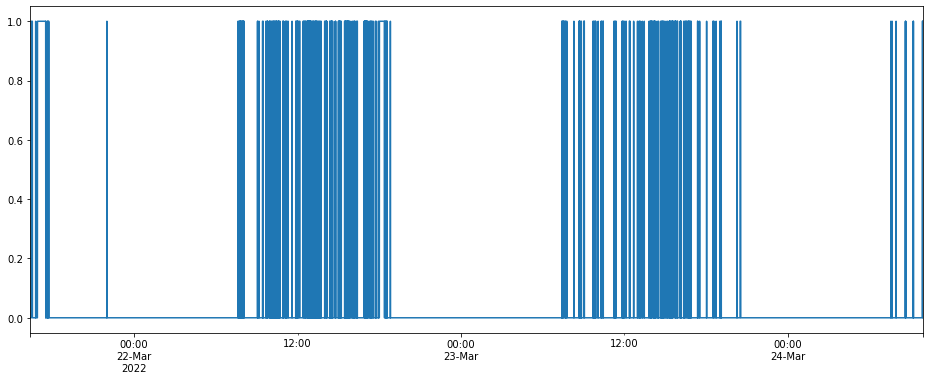

In [81]:
DF_in_and_out_area[-1].loc[:,"event"].interpolate(method='linear').plot(figsize = (16,6))

wow...this looks so much cleaner than the Reolink notifications. Our goal was to reduce annoyning alerts and I think this alredy demonstrates the clear achievement we have done - from a really bad commercial product that is shooting alerts with such a high frequent false and surprisingly also negative alerts (the latter could also be validated by looking at the videos). Now lets have the events next to each other for better comparison 

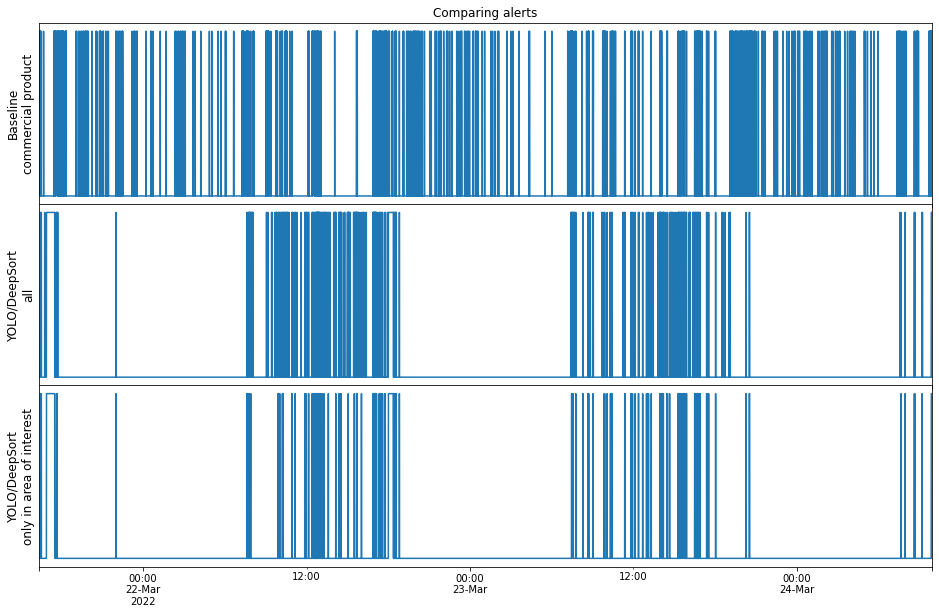

In [82]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,1, figsize = (16,10), sharex = True)

ax[0].set_title("Comparing alerts", rotation=0, size='large')

ax[0].set_ylabel("Baseline\ncommercial product", rotation=90, size='large')
reo1.loc[:,"Alarm"].interpolate(method='linear').plot( ax=ax[0])
ax[0].axes.get_yaxis().set_ticks([])

ax[1].set_ylabel("YOLO/DeepSort\nall", rotation=90, size='large')
DF_in_and_out_area[5].loc[:,"event"].interpolate(method='linear').plot(ax=ax[1])
ax[1].axes.get_yaxis().set_ticks([])

DF_in_area[5].loc[:,"event"].interpolate(method='linear').plot(ax=ax[2])
ax[2].axes.get_yaxis().set_ticks([])
ax[2].set_ylabel("YOLO/DeepSort\nonly in area of interest", rotation=90, size='large')

plt.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()

the picture speaks for itself :-D as our downstream analysis (detecting a face and identifying the person) is just a subset of the YOLO/DeepSORT (only in interest area) we will reduce the annoying alerts further. Especially because we saw that we have a recall of 100% for identifying the unknown person (note: precision pretty bad but we are reducing the alerts again by around 50% from YOLO events that occur only in interest area without missing the true unknown person) estimated and illustrated in the [smart_surveillance/03_model_evaluation.ipynb](smart_surveillance/03_model_evaluation.ipynb) notebook. We are really happy with these results and hope that we can even further improve this great archivement when we implement a feedback mechanism that let the models train over time and takes the face images directly from the surveillance camera than from our personal picture collection which will have very likely better properties to align the faces from the camera. we are reall curious to see the performance after we collected some more data to illustrate that beyond capstone 

In [89]:
# import os
# path = [l for l in  os.listdir("smart_surveillance/log/") if re.match("YOLO4_DeepSORT_Eingang_.*.log", l)]

# print(path[0])
# DF_in_and_out_area, DF_in_area, startings = clean_YOLO_log("smart_surveillance/log/" + path[0])

# DF_in =DF_in_area[0].copy()
# DF_in_out =DF_in_and_out_area[0].copy()
# for i in range(1,len(DF_in_area)):
#     DF_in = DF_in.append(DF_in_area[0]) 
#     DF_in_out =DF_in_out.append(DF_in_and_out_area[0])
        
# for j in range(1,len(path)):
#     print(path[j])
#     try:
#         DF_in_and_out_area, DF_in_area, startings = clean_YOLO_log("smart_surveillance/log/" + path[j])
#     except:
#         print(f"missing log: {'smart_surveillance/log/' + path[j]}")
#         continue
    
# #     DF_in =DF_in_area[0].copy()
# #     DF_in_out =DF_in_and_out_area[0].copy()
#     for k in range(len(DF_in_area)):
#         DF_in = DF_in.append(DF_in_area[k]) 
#         DF_in_out =DF_in_out.append(DF_in_and_out_area[k])

# # # reo
# # for r,skip in zip(path[1:], [32,48,8,8,8,8,8]):
# #     print(r)
# #     reo = reo.append(clean_reolink_log("Reolink/log/" + r, skip))
    
# # reo.shape

# DF_in.loc[:,"event"].interpolate(method='linear').plot(figsize = (16,6))